#### This Notebook for explain How to use genetic algorithm for optimization to select the best features from cnn architecture like mobilenetv2 and make it more faster and more accurate and make calsification task using svm classifier


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input, BatchNormalization, Activation, concatenate, GlobalAveragePooling2D, AveragePooling2D, GlobalMaxPooling2D
from keras.optimizers import Adam


## Load Data

In [2]:
from skimage.transform import resize
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import shuffle

# Load brain tumor detection dataset
input_path = 'e:\\university\\Project_Karshenasi'
yes = os.path.join(input_path, 'COVID')
no = os.path.join(input_path, 'non-COVID')

labels = ['COVID', 'Non-COVID']

# Load images
yes_list = os.listdir(yes)
no_list = os.listdir(no)


# Array to store images
X = []
y = []
IMG_SIZE = (128, 128)

# Load images with tumor
for i in range(len(yes_list)):
    file_path = os.path.join(yes, yes_list[i])

    if os.path.exists(file_path):
        img = plt.imread(file_path)
        img_resized = resize(img, IMG_SIZE + (3,))  # Ensure 3 channels for RGB
        X.append(img_resized)
        y.append(1)
    else:
        print(f"File not found: {file_path}")

# Load images without tumor
for i in range(len(no_list)):
    file_path = os.path.join(no, no_list[i])
    if os.path.exists(file_path):
        img = plt.imread(file_path)
        img_resized = resize(img, IMG_SIZE + (3,))  # Ensure 3 channels for RGB
        X.append(img_resized)
        y.append(0)
    else:
        print(f"File not found: {file_path}")

# Convert to numpy array
X = np.array(X)
y = np.array(y)

# Shuffle data
X, y = shuffle(X, y, random_state=42)


In [3]:
X.shape,y.shape

((2481, 128, 128, 3), (2481,))

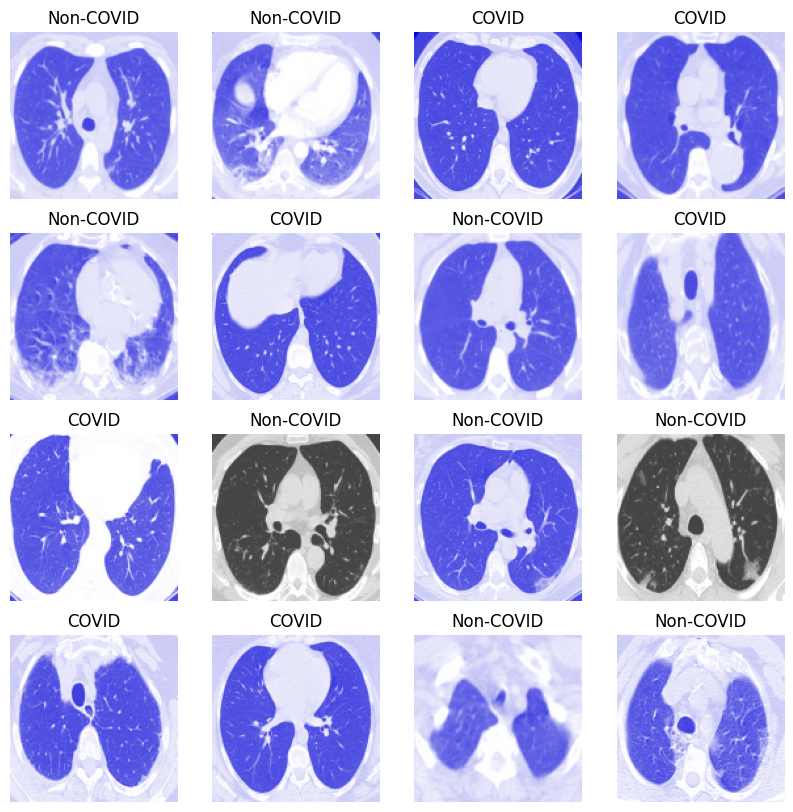

In [4]:
# plot some images
plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(X[i])
    plt.title(labels[y[i]])
    plt.axis('off')

## Data Preparation

In [7]:
# split data into train and test 20% test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)

# # normalize data
 #X_train = X_train / 255
 #X_test = X_test / 255

# one hot encode target
from keras.utils import to_categorical
y_train_to_categorical = to_categorical(y_train)
y_test_to_categorical = to_categorical(y_test)

print(X_train.shape, X_test.shape, y_train_to_categorical.shape, y_test_to_categorical.shape)

(1984, 128, 128, 3) (497, 128, 128, 3) (1984, 2) (497, 2)


In [8]:
from keras.applications import mobilenet_v2

# Define the absolute path to the downloaded weights file
local_weights_file = 'e:\\university\\Project_Karshenasi\\mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_128_no_top.h5'

# Load the MobileNetV2 model with random weights
mobile_net_v2_model = mobilenet_v2.MobileNetV2(weights=None, include_top=False, input_shape=(128, 128, 3))

# Load the weights from the local file
mobile_net_v2_model.load_weights(local_weights_file)


In [8]:
# Freeze the already-trained layers in the model
for layer in mobile_net_v2_model.layers:
    layer.trainable = False
    
# add custom layers
model = Sequential()
model.add(mobile_net_v2_model)
model.add(GlobalAveragePooling2D())

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ ?                      │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [9]:
feature_train = model.predict(X_train)
feature_test = model.predict(X_test)

62/62 ━━━━━━━━━━━━━━━━━━━━ 18s 248ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 341ms/step


In [10]:
print(feature_train.shape, feature_test.shape)

(1984, 1280) (497, 1280)


In [11]:
# Flatten extracted features
flat_train = feature_train.reshape(feature_train.shape[0], -1)
flat_test = feature_test.reshape(feature_test.shape[0], -1)

In [12]:
print(flat_train.shape, flat_test.shape)

(1984, 1280) (497, 1280)


In [13]:
y_train_flattened=y_train.ravel()
y_test_flattened=y_test.ravel()
y_train_flattened.shape,y_test_flattened.shape

((1984,), (497,))

## Genatic Algorithm
> is a metaheuristic inspired by the process of natural selection that belongs to the larger class of evolutionary algorithms (EA). Genetic algorithms are commonly used to generate high-quality solutions to optimization and search problems by relying on biologically inspired operators such as mutation, crossover and selection.

In [22]:
# use genatic algorithm to find best features to use
from sklearn.svm import SVC
# Genetic Algorithm Parameters
POP_SIZE = 10
GENES = flat_train.shape[1]
GENERATIONS = 50
MUTATION_RATE = 0.01
CROSSOVER_RATE = 0.7
AVERAGE_ACC = [] # Average accuracy of each generation

# Initialize population
def initialize_population(population_size, genes):
    return np.random.choice([0, 1], size=(population_size, genes))

# Evaluate fitness using nn classifier
def evaluate_fitness(population, X_train, X_test, y_train, y_test):
    fitness_values = []
    for chromosome in population:
        selected_features = np.where(chromosome == 1)[0]
        if len(selected_features) == 0:
            fitness_values.append(0)
            continue
        X_train_selected = X_train[:, selected_features]
        X_test_selected = X_test[:, selected_features]
        model = SVC(kernel='poly', C=1)
        model.fit(X_train_selected, y_train)
        test_acc = model.score(X_test_selected, y_test)
        print('Acc:', test_acc)
        fitness_values.append(test_acc)

    return np.array(fitness_values)

# Perform crossover
def crossover(parent1, parent2):
    crossover_point = np.random.randint(0, len(parent1))
    child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
    child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
    return child1, child2

# Perform mutation
def mutate(child):
    mutation_mask = np.random.rand(len(child)) < MUTATION_RATE
    child[mutation_mask] = 1 - child[mutation_mask]  # Flip the bits
    return child

# Main Genetic Algorithm
def genetic_algorithm(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    population = initialize_population(POP_SIZE, GENES)

    for generation in range(GENERATIONS):
        print(f'=========================================== generation:{generation} =========================================== ')
        fitness_values = evaluate_fitness(population, X_train, X_test, y_train, y_test)
        selected_indices = np.argsort(fitness_values)[::-1][:int(POP_SIZE * CROSSOVER_RATE)]

        new_population = []
        AVERAGE_ACC.append(np.mean(fitness_values))
        # Perform crossover and mutation
        for _ in range(0, POP_SIZE, 2):
            parent1 = population[np.random.choice(selected_indices)]
            parent2 = population[np.random.choice(selected_indices)]
            child1, child2 = crossover(parent1, parent2)
            child1 = mutate(child1)
            child2 = mutate(child2)
            new_population.extend([child1, child2])

        population = np.array(new_population)

    best_individual = population[np.argmax(fitness_values)]
    selected_features = np.where(best_individual == 1)[0]
    return selected_features

# usage
selected_features = genetic_algorithm(flat_train, y_train_flattened)
print("Selected Features:", selected_features)

=========================================== generation:0 =========================================== 
Acc: 0.9395465994962217
Acc: 0.9168765743073047
Acc: 0.9370277078085643
Acc: 0.9345088161209067
Acc: 0.9118387909319899
Acc: 0.924433249370277
Acc: 0.924433249370277
Acc: 0.9143576826196473
Acc: 0.9093198992443325
Acc: 0.9168765743073047
=========================================== generation:1 =========================================== 
Acc: 0.9345088161209067
Acc: 0.9269521410579346
Acc: 0.9168765743073047
Acc: 0.9370277078085643
Acc: 0.9168765743073047
Acc: 0.924433249370277
Acc: 0.929471032745592
Acc: 0.9370277078085643
Acc: 0.929471032745592
Acc: 0.9269521410579346
=========================================== generation:2 =========================================== 
Acc: 0.9319899244332494
Acc: 0.9269521410579346
Acc: 0.9193954659949622
Acc: 0.9345088161209067
Acc: 0.9319899244332494
Acc: 0.9319899244332494
Acc: 0.924433249370277
Acc: 0.9370277078085643
Acc: 0.9395465994962217
Acc:

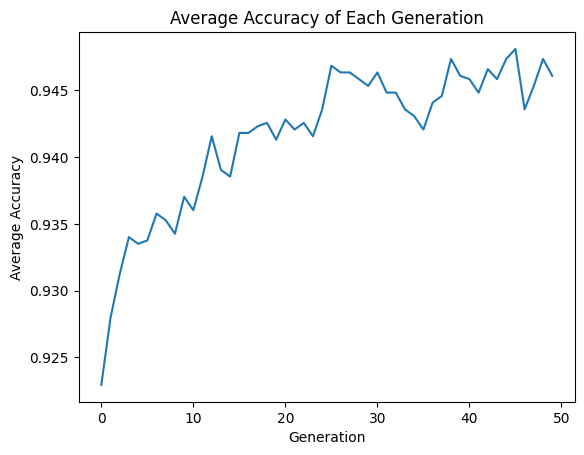

In [24]:
# plot the average accuracy of each generation
plt.plot(AVERAGE_ACC)
plt.xlabel('Generation')
plt.ylabel('Average Accuracy')
plt.title('Average Accuracy of Each Generation')
plt.show()

In [25]:
flat_train[:, selected_features].shape

(1984, 638)

In [26]:
flat_train_selected_features=flat_train[:, selected_features]
flat_test_selected_features=flat_test[:, selected_features]

## Tarin svm model on selected features

In [27]:
# tarin svm model on all features
model = SVC(kernel='poly', C=1)
model.fit(flat_train_selected_features, y_train)
test_acc = model.score(flat_test_selected_features, y_test)
print('Acc:', test_acc)

Acc: 0.9356136820925554


## Predictions on test data

(497,)


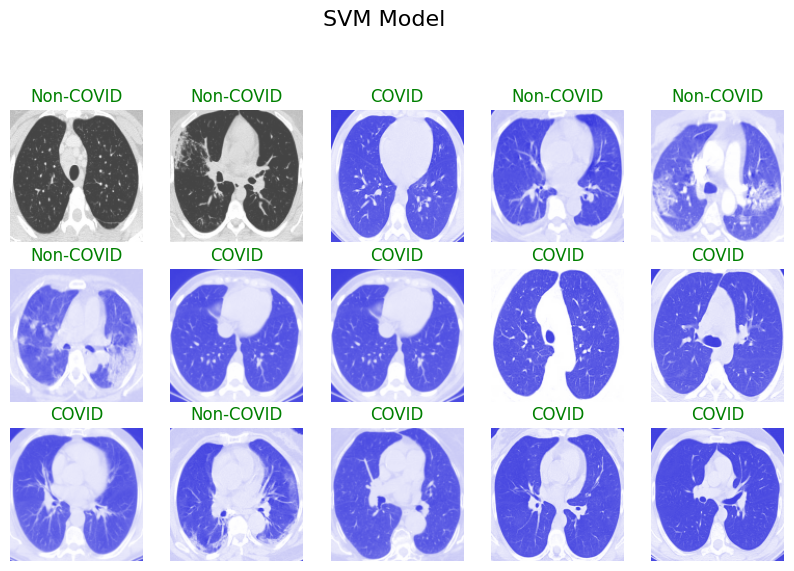

In [29]:
# predict on test data
predictions = model.predict(flat_test_selected_features)
print(predictions.shape)

# plot the results
plt.figure(figsize=(10,10))
for i in range(15):
    n=np.random.randint(0, len(predictions))
    plt.subplot(5,5,i+1)
    plt.imshow(X_test[n])
    plt.title(f'{labels[predictions[n]]}',color="red" if y_test[n]!=predictions[n] else "green")
    plt.suptitle('SVM Model', fontsize=16)
    plt.axis('off')
    

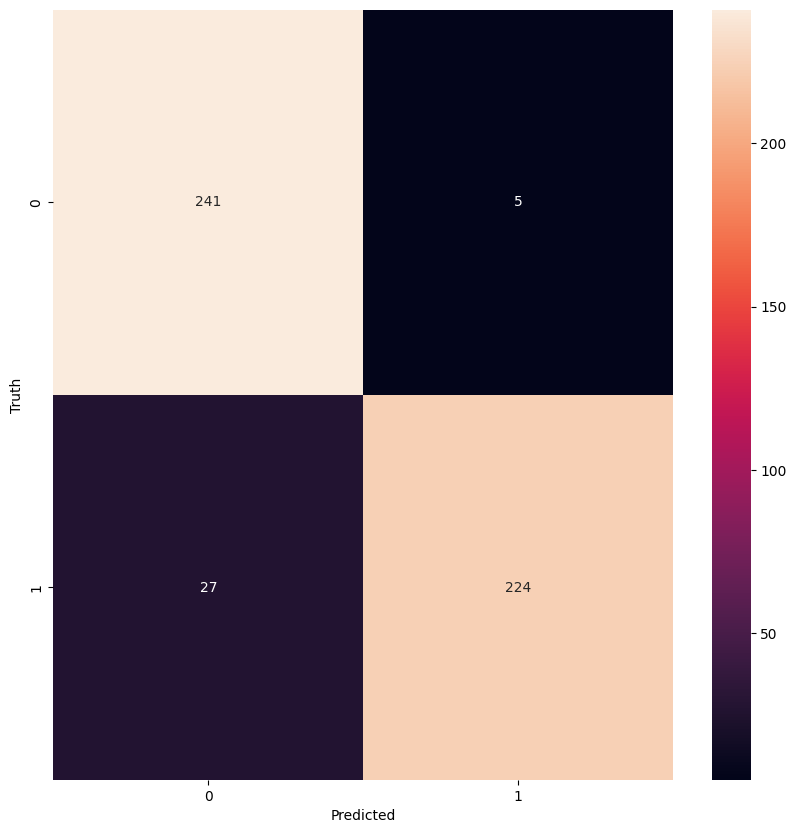

In [31]:
# confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predictions)
# heatmap
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()


In [33]:
# classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94       246
           1       0.98      0.89      0.93       251

    accuracy                           0.94       497
   macro avg       0.94      0.94      0.94       497
weighted avg       0.94      0.94      0.94       497

